**README**

The code file is ipynb file. Only Requirement to run it is anaconda3. And the packages and all
the remaining modules are directly imported just by running the notebook.

In [2]:
!pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 10.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import datetime
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

In [4]:
train_data = pd.read_csv("train.csv")

In [5]:
test_data = pd.read_csv("test.csv")

In [6]:
train_data.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [7]:
train_data.shape

(116058, 29)

*Removing the loan_id column according to guidelines*

In [8]:
train_data = train_data.drop(['loan_id'],axis=1)
train_data.shape

(116058, 28)

In [9]:
test_data = test_data.drop(['loan_id'],axis=1)
test_data.shape

(35866, 27)

## Checking duplicates

In [10]:
train_data = train_data.drop_duplicates()
train_data.shape

(116042, 28)

*There are 16 duplicates in the given dataset*

## Checking the null values in each feature

In [11]:
print(f"Sum of null values in each feature:\n{20 * '-'}")
print(f"{train_data.isnull().sum()}")

Sum of null values in each feature:
--------------------
source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
m13                         0
dtype: int64


*There are no null values in the dataset then we are good to continue.*

## Target Variable Analysis

In [12]:
train_data['m1'].value_counts()

m1
0    115713
1       293
2        30
3         6
Name: count, dtype: int64

In [13]:
non_deliquency_percentage = train_data['m1'].value_counts()[0]/(train_data['m1'].value_counts()[0]+train_data['m1'].value_counts()[1])
print("Non deliquency percentage",non_deliquency_percentage*100)

Non deliquency percentage 99.74742685723153


In [14]:
deliquency_percentage = train_data['m1'].value_counts()[1]/(train_data['m1'].value_counts()[0]+train_data['m1'].value_counts()[1])
print("Deliquency percentage",deliquency_percentage*100)

Deliquency percentage 0.2525731427684775


**It seems like only 0.5 percent of loans(data points) are deliquent. So if all the data points are predicted as 0(non deliquent) we will get 99.5percent accuracy so instead we see confusion matrix to asses the model quality**

**Data is highly imbalanced so we have to handle imbalanced data using SMOTE,MSMOTE with boosting and bagging algorithms to avoid overfitting and also we can use clustering techniques for oversampling and underssampling**

In [15]:
print(train_data['source'].value_counts())
train_data['financial_institution'].value_counts()

source
X    63848
Y    37549
Z    14645
Name: count, dtype: int64


financial_institution
OTHER                          49690
Browning-Hart                  31848
Swanson, Newton and Miller      6874
Edwards-Hoffman                 4857
Martinez, Duffy and Bird        4715
Miller, Mcclure and Allen       3158
Nicholson Group                 2116
Turner, Baldwin and Rhodes      1846
Suarez Inc                      1790
Cole, Brooks and Vincent        1641
Richards-Walters                1459
Taylor, Hunt and Rodriguez      1259
Sanchez-Robinson                1193
Sanchez, Hays and Wilkerson      852
Romero, Woods and Johnson        750
Thornton-Davis                   651
Anderson-Taylor                  482
Richardson Ltd                   473
Chapman-Mcmahon                  388
Name: count, dtype: int64

## Converting source and financial categorical features to numerical

In [16]:
train_data['source'] = train_data['source'].astype('category')
train_data['financial_institution'] = train_data['financial_institution'].astype('category')
train_data['loan_purpose'] = train_data['loan_purpose'].astype('category')

cat_columns = train_data.select_dtypes(['category']).columns
train_data[cat_columns] = train_data[cat_columns].apply(lambda x : x.cat.codes)

train_data[cat_columns].head()

,source,financial_institution,loan_purpose
0,2,18,2
1,1,15,1
2,2,17,1
3,0,8,1
4,0,8,2


In [17]:
test_data['source'] = test_data['source'].astype('category')
test_data['financial_institution'] = test_data['financial_institution'].astype('category')
test_data['loan_purpose'] = test_data['loan_purpose'].astype('category')

cat_columns = test_data.select_dtypes(['category']).columns
test_data[cat_columns] = test_data[cat_columns].apply(lambda x : x.cat.codes)

test_data[cat_columns].head()

,source,financial_institution,loan_purpose
0,1,1,0
1,0,8,2
2,1,8,2
3,0,6,0
4,0,1,0


## Handling date featuers

In [18]:
train_data.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')

In [19]:
train_data['origination_date'] = pd.to_datetime(train_data['origination_date'])
train_data['origination_year'] = train_data['origination_date'].apply(lambda x : x.year)

train_data['origination_month'] = train_data['origination_date'].apply(lambda x : x.month)

train_data = train_data.drop(['origination_date'],axis=1)

In [20]:
test_data['origination_date'] = pd.to_datetime(test_data['origination_date'])
test_data['origination_year'] = test_data['origination_date'].apply(lambda x : x.year)
test_data['origination_month'] = test_data['origination_date'].apply(lambda x : x.month)
test_data = test_data.drop(['origination_date'],axis=1)

C:\Users\kusha\AppData\Local\Temp\ipykernel_27536\3108670101.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['origination_date'] = pd.to_datetime(test_data['origination_date'])


In [21]:
train_data.shape

(116042, 29)

In [22]:
train_data['first_payment_year'] = train_data['first_payment_date'].apply(lambda x : x.split("/")[1])

train_data['first_payment_month'] = train_data['first_payment_date'].apply(lambda x : x.split("/")[0])

train_data = train_data.drop(['first_payment_date'],axis=1)

In [23]:
test_data['first_payment_year'] = test_data['first_payment_date'].apply(lambda x : x.split("-")[1])
test_data['first_payment_month'] = test_data['first_payment_date'].apply(lambda x : x.split("-")[0])
test_data = test_data.drop(['first_payment_date'],axis=1)

In [24]:
test_data.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,...,m7,m8,m9,m10,m11,m12,origination_year,origination_month,first_payment_year,first_payment_month
0,1,1,3.875,417000,360,75,1,20,790,0,...,0,0,0,0,0,0,2012,1,12,Apr
1,0,8,4.500,113000,360,80,2,33,793,2,...,0,0,0,0,0,0,2012,1,12,Apr
2,1,8,4.500,72000,360,75,1,34,710,2,...,0,0,0,0,0,0,2012,1,12,Mar
3,0,6,4.125,123000,180,41,2,24,798,0,...,0,0,0,0,0,0,2012,1,12,Apr
4,0,1,3.250,166000,180,53,2,12,767,0,...,0,0,0,0,0,0,2012,1,12,Apr


In [25]:
test_data['first_payment_month'].value_counts()

first_payment_month
Apr    16551
Mar    14661
May     4510
Feb      144
Name: count, dtype: int64

In [26]:
month = {'Feb':'02','Mar':'03','Apr':'04','May':'05'}
test_data.first_payment_month = test_data.first_payment_month.map(month)

In [27]:
train_data.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,...,m8,m9,m10,m11,m12,m13,origination_year,origination_month,first_payment_year,first_payment_month
0,2,18,4.250,214000,360,95,1.0,22.0,694.0,2,...,0,0,0,0,0,1,2012,3,2012,05
1,1,15,4.875,144000,360,72,1.0,44.0,697.0,1,...,0,0,0,1,0,1,2012,1,2012,03
2,2,17,3.250,366000,180,49,1.0,33.0,780.0,1,...,0,0,0,0,0,1,2012,1,2012,03
3,0,8,4.750,135000,360,46,2.0,44.0,633.0,1,...,0,1,1,1,1,1,2012,2,2012,04
4,0,8,4.750,124000,360,80,1.0,43.0,681.0,2,...,7,8,9,10,11,1,2012,2,2012,04


In [28]:
test_data.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,...,m7,m8,m9,m10,m11,m12,origination_year,origination_month,first_payment_year,first_payment_month
0,1,1,3.875,417000,360,75,1,20,790,0,...,0,0,0,0,0,0,2012,1,12,04
1,0,8,4.500,113000,360,80,2,33,793,2,...,0,0,0,0,0,0,2012,1,12,04
2,1,8,4.500,72000,360,75,1,34,710,2,...,0,0,0,0,0,0,2012,1,12,03
3,0,6,4.125,123000,180,41,2,24,798,0,...,0,0,0,0,0,0,2012,1,12,04
4,0,1,3.250,166000,180,53,2,12,767,0,...,0,0,0,0,0,0,2012,1,12,04


In [29]:
from sklearn.preprocessing import StandardScaler
standard = StandardScaler()
train_data['unpaid_principal_bal'] = standard.fit_transform(train_data['unpaid_principal_bal'].values.reshape(-1, 1))
test_data['unpaid_principal_bal'] = standard.transform(test_data['unpaid_principal_bal'].values.reshape(-1, 1))


# Univariate Analysis

In [30]:
train_data.columns

Index(['source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'loan_to_value',
       'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score',
       'loan_purpose', 'insurance_percent', 'co-borrower_credit_score',
       'insurance_type', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       'm10', 'm11', 'm12', 'm13', 'origination_year', 'origination_month',
       'first_payment_year', 'first_payment_month'],
      dtype='object')

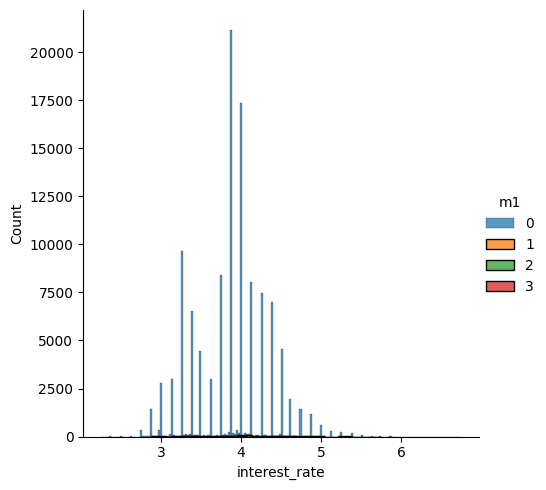

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.FacetGrid(train_data, hue="m1", height=5).map(sns.histplot, "interest_rate").add_legend()
plt.show()


*There is considerable overlap between two pdfs. interest rate alone cannot be used to separate deliquency*

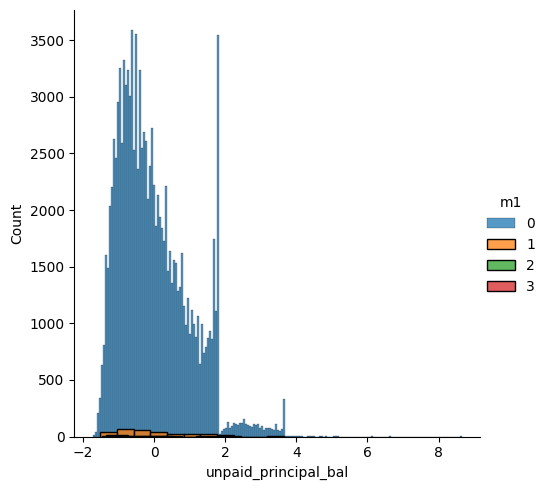

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use histplot for histograms or kdeplot for kernel density plots
sns.FacetGrid(train_data, hue="m1", height=5).map(sns.histplot, "unpaid_principal_bal").add_legend()
plt.show()


*It seems like pdfs are overlapping a lot. So the features alone cannot be used to classify deliquency*

**In order to handle imbalanced data we have to use k-fold cross validation and SMOTE or clustering sampling techniques**

**PCA**

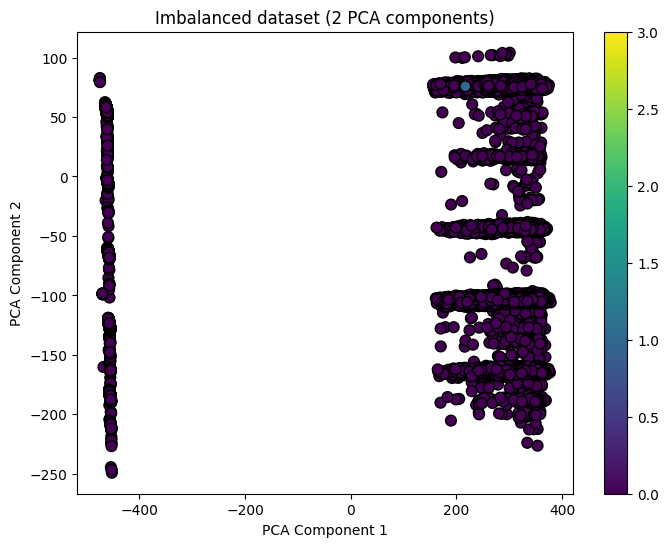

In [38]:
import matplotlib.pyplot as plt
import numpy as np

def plot_2d_space(X, labels, title="PCA Plot"):
    """
    Function to plot 2D space for PCA components.
    X: 2D array, shape (n_samples, 2), PCA components.
    labels: true labels of the data.
    title: title for the plot.
    """
    # Create the scatter plot
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='k', s=60)
    
    # Add color bar
    plt.colorbar(scatter)
    
    # Labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    
    # Show the plot
    plt.show()

# Example of usage
from sklearn.decomposition import PCA

# Assuming you have a dataset called `train_data` and labels `labels`
pca = PCA(n_components=2)
X = pca.fit_transform(train_data)  # Apply PCA
plot_2d_space(X, labels, 'Imbalanced dataset (2 PCA components)')


# OverSampling(SMOTE)

In [37]:
labels = train_data['m1']
train_data = train_data.drop(['m1'],axis=1)

In [39]:
X_train,X_test,Y_train,Y_test = train_test_split(train_data,labels,test_size=0.3,random_state=42,stratify = labels)

In [40]:
print(Y_train.value_counts())
print(Y_test.value_counts())

m1
0    80999
1      205
2       21
3        4
Name: count, dtype: int64
m1
0    34714
1       88
2        9
3        2
Name: count, dtype: int64


In [41]:
X_train.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,...,m8,m9,m10,m11,m12,m13,origination_year,origination_month,first_payment_year,first_payment_month
73963,2,6,3.250,-0.560146,120,67,2.0,40.0,800.0,1,...,0,0,0,0,0,0,2012,1,2012,03
105720,1,4,3.625,1.131443,240,60,2.0,28.0,774.0,0,...,0,0,0,0,0,0,2012,3,2012,05
45107,1,1,4.625,-1.048439,360,80,1.0,40.0,796.0,2,...,0,0,0,0,0,0,2012,1,2012,03
49495,1,8,4.625,-1.466977,360,80,1.0,28.0,776.0,1,...,0,0,0,0,0,0,2012,1,2012,03
105391,2,1,3.500,-0.926366,180,95,1.0,39.0,758.0,0,...,0,0,0,0,0,0,2012,1,2012,03


In [46]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with reduced k_neighbors (for example, set to 3)
sm = SMOTE(random_state=42, k_neighbors=3)

# Apply SMOTE to oversample the training data
X_train, Y_train = sm.fit_resample(X_train, Y_train)

# Check the shape of the resampled data and the distribution of labels
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train.shape))

# Print the count of instances for each class after oversampling
print("After OverSampling, counts of label '1': {}".format(sum(Y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train == 0)))


After OverSampling, the shape of train_X: (323996, 29)
After OverSampling, the shape of train_y: (323996,) 

After OverSampling, counts of label '1': 80999
After OverSampling, counts of label '0': 80999


In [37]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(Y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(Y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train==0)))

After OverSampling, the shape of train_X: (161568, 29)
After OverSampling, the shape of train_y: (161568,) 

After OverSampling, counts of label '1': 80784
After OverSampling, counts of label '0': 80784


In [47]:
def xgboost_gridsearch(X_1,Y_1):
    xgb_model = xgb.XGBClassifier(n_jobs = -1)
    grid_parameters = {
    'learning_rate': [0.125, 0.0625, 0.03, 0.015, 0.01 ],
    'max_depth' :[3,4,5,6,7,8],
    'n_estimators' : [5,6,7,8,9,10,11,12,13,14]
    }

    print('*******GRID SEARCH*********')
    grid_search = GridSearchCV(xgb_model, grid_parameters, scoring = 'f1', cv=3)
    grid_search.fit(X_1,Y_1)
    print(grid_search.best_estimator_)

In [62]:
from sklearn.metrics import make_scorer, f1_score

def xgboost_gridsearch_high(X_1, Y_1):
    xgb_model = xgb.XGBClassifier(n_jobs=-1)
    grid_parameters = {
        'learning_rate': [0.125, 0.03, 0.015, 0.01],
        'max_depth': [2, 7, 10],
        'n_estimators': [150, 200, 250, 500, 1000]
    }

    f1_weighted_scorer = make_scorer(f1_score, average='weighted')

    print('*******GRID SEARCH*********')
    grid_search = GridSearchCV(xgb_model, grid_parameters, scoring=f1_weighted_scorer, cv=3)
    grid_search.fit(X_1, Y_1)
    print("Best Estimator:\n", grid_search.best_estimator_)


In [63]:
def random_forest(X_1,Y_1):
    rf_model = RandomForestClassifier(n_jobs=-1)
    grid_parameters = {
    'min_samples_split' :[2,7,10],
    'n_estimators' : [150,200,250,500,1000]
    }
    print('*******GRID SEARCH*********')
    grid_search = GridSearchCV(rf_model, grid_parameters, scoring = 'f1_weighted', cv=3)
    grid_search.fit(X_1,Y_1)
    print(grid_search.best_estimator_)
        

In [64]:
# Convert object columns to category, then to numeric codes
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category').cat.codes

for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = X_test[col].astype('category').cat.codes


In [77]:
xgboost_gridsearch(X_train,Y_train)

*******GRID SEARCH*********


c:\Users\kusha\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\kusha\anaconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kusha\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kusha\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^

KeyboardInterrupt: 

In [66]:
%%time
xgboost_gridsearch_high(X_train,Y_train)

*******GRID SEARCH*********


KeyboardInterrupt: 

In [68]:
import numpy as np
X_train = X_train.replace([None], np.nan)


In [69]:
xgboost_optimal = XGBClassifier(
    booster='gbtree', 
    colsample_bytree=1, 
    gamma=0, 
    learning_rate=0.125, 
    max_depth=8, 
    reg_alpha=0, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    subsample=1, 
    verbosity=1,
    missing=np.nan  # Explicitly set missing value handling
)
xgboost_optimal.fit(X_train, Y_train)
pred = xgboost_optimal.predict(X_train)


c:\Users\kusha\anaconda3\envs\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:14:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [71]:

import numpy as np
X_train = X_train.replace([None, 'null'], np.nan)


In [72]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Example data split (you should replace this with your actual dataset)
# X_train, Y_train should be defined already (train data and target labels)

# Handling missing values in the training data (if any)
# Convert non-numeric or invalid values to np.nan
X_train = X_train.apply(pd.to_numeric, errors='coerce')  # Ensuring all data is numeric
Y_train = Y_train.apply(pd.to_numeric, errors='coerce')  # If Y_train has any non-numeric values

# Ensure missing values are represented as np.nan
X_train = X_train.replace([None, 'null'], np.nan)  # Replace None or 'null' with np.nan
Y_train = Y_train.replace([None, 'null'], np.nan)  # Replace None or 'null' with np.nan

# Initialize XGBoost Classifier with optimal hyperparameters
xgboost_optimal_high = XGBClassifier(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=1,
    colsample_bynode=1, 
    colsample_bytree=1, 
    gamma=0,
    learning_rate=0.01, 
    max_delta_step=0, 
    max_depth=10,
    reg_alpha=0, 
    reg_lambda=1, 
    subsample=1, 
    verbosity=1, 
    missing=np.nan  # Handle missing values explicitly
)

# Fit the model on the training data
xgboost_optimal_high.fit(X_train, Y_train)

# Make predictions on the training data
pred = xgboost_optimal_high.predict(X_train)

# Optionally, print predictions to verify
print(pred)


[0 0 0 ... 3 3 3]


In [73]:
pred_cv = xgboost_optimal_high.predict(X_test)
print(confusion_matrix(Y_test,pred_cv))

confusion_matrix(Y_train,pred)

[[32318  1719   159   518]
 [   75    11     1     1]
 [    8     1     0     0]
 [    1     1     0     0]]


array([[75842,  2445,  2226,   486],
       [ 1445, 77399,  1850,   305],
       [   28,    12, 80959,     0],
       [    1,     0,     0, 80998]], dtype=int64)

In [79]:
from sklearn.metrics import f1_score

# Use 'micro', 'macro', or 'weighted' based on your preference
f1 = f1_score(Y_train, pred, average='macro')  # For example, 'macro' average
print(f1)


0.9727011981335232


In [42]:
print(confusion_matrix(Y_train,pred))
pred_cv = xgboost_optimal_high.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

[[80753    31]
 [  193 80591]]


array([[34569,    53],
       [  115,    76]])

In [43]:
f1_score(Y_test,pred_cv)

0.475

In [76]:
test_data = test_data.astype(int)

test_data = np.array(test_data)

test_predictions = xgboost_optimal_high.predict(test_data)

submission = pd.read_csv('sample_submission.csv')

submission['m13'] = test_predictions

pd.DataFrame(submission).to_csv("submission3.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

## Random Forest

In [260]:
random_forest(X_train,Y_train)

*******GRID SEARCH*********
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [44]:
rf_optimal = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
rf_optimal.fit(X_train,Y_train)
pred = rf_optimal.predict(X_train)

In [45]:
print(confusion_matrix(Y_train,pred))
pred_cv = rf_optimal.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

[[80784     0]
 [    0 80784]]


array([[34576,    46],
       [  114,    77]])

In [46]:
print(f1_score(Y_train,pred))
f1_score(Y_test,pred_cv)

1.0


0.4904458598726115

In [261]:
test_data = test_data.astype(int)

test_data = np.array(test_data)

test_predictions = rf_optimal.predict(test_data)

submission = pd.read_csv('sample_submission.csv')

submission['m13'] = test_predictions

pd.DataFrame(submission).to_csv("rf.csv",index=False)

## Stacking Classifier

In [50]:
clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.125, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier=clf1, use_probas=True)
sclf.fit(X_train,Y_train)
pred = sclf.predict(X_train)

In [51]:
print(confusion_matrix(Y_train,pred))
pred_cv = sclf.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

[[80784     0]
 [    0 80784]]


array([[34578,    44],
       [  117,    74]])

In [52]:
print(f1_score(Y_train,pred))
f1_score(Y_test,pred_cv)

1.0


0.4789644012944984

In [268]:
test_data = test_data.astype(int)

test_data = np.array(test_data)

test_predictions = sclf.predict(test_data)

submission = pd.read_csv('sample_submission.csv')

submission['m13'] = test_predictions

pd.DataFrame(submission).to_csv("stacking_classifier.csv",index=False)

In [269]:
clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.125, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


sclf = StackingClassifier(classifiers=[clf1, clf2], meta_classifier=clf1, use_probas=True)
sclf.fit(X_train,Y_train)
pred = sclf.predict(X_train)

In [270]:
print(confusion_matrix(Y_train,pred))
pred_cv = sclf.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

[[80784     0]
 [    0 80784]]


array([[34580,    42],
       [  111,    80]])

In [271]:
print(f1_score(Y_train,pred))
f1_score(Y_test,pred_cv)

1.0


0.5111821086261982

In [272]:
test_data = test_data.astype(int)

test_data = np.array(test_data)

test_predictions = sclf.predict(test_data)

submission = pd.read_csv('sample_submission.csv')

submission['m13'] = test_predictions

pd.DataFrame(submission).to_csv("stacking_classifier_with_meta_rf.csv",index=False)

## Extremely Randomized Trees

In [45]:
def extreme_random_forest(X_1,Y_1):
    rf_model = ExtraTreesClassifier(n_jobs=-1)
    grid_parameters = {
    'min_samples_split' :[2,7,10],
    'n_estimators' : [150,200,250,500,1000]
    }
    print('*******GRID SEARCH*********')
    grid_search = GridSearchCV(rf_model, grid_parameters, scoring = 'f1', cv=3)
    grid_search.fit(X_1,Y_1)
    print(grid_search.best_estimator_)

In [46]:
extreme_random_forest(X_train,Y_train)

*******GRID SEARCH*********
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


In [275]:
erf_optimal = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
erf_optimal.fit(X_train,Y_train)
pred = erf_optimal.predict(X_train)

In [277]:
print(confusion_matrix(Y_train,pred))
pred_cv = erf_optimal.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

[[80784     0]
 [    0 80784]]


array([[34567,    55],
       [  101,    90]])

In [278]:
print(f1_score(Y_train,pred))
f1_score(Y_test,pred_cv)

1.0


0.5357142857142857

In [280]:
test_data = test_data.astype(int)

test_data = np.array(test_data)

test_predictions = erf_optimal.predict(test_data)

submission = pd.read_csv('sample_submission.csv')

submission['m13'] = test_predictions

pd.DataFrame(submission).to_csv("extremerf.csv",index=False)

## Stacking Classifier with Extreme Random Forest

In [64]:
clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.125, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

clf3 = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=clf3, use_probas=True)
sclf.fit(X_train,Y_train)
pred = sclf.predict(X_train)

In [65]:
print(confusion_matrix(Y_train,pred))
pred_cv = sclf.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

[[80784     0]
 [    0 80784]]


array([[34569,    53],
       [  103,    88]])

In [66]:
print(f1_score(Y_train,pred))
f1_score(Y_test,pred_cv)

1.0


0.5301204819277109

In [67]:
test_data = test_data.astype(int)

test_data = np.array(test_data)

test_predictions = sclf.predict(test_data)

submission = pd.read_csv('sample_submission.csv')

submission['m13'] = test_predictions

pd.DataFrame(submission).to_csv("stacking_classifier_extreme_with_meta_extreme_standardized.csv",index=False)

# Undersampling(near miss)

In [205]:
X_train,X_test,Y_train,Y_test = train_test_split(train_data,labels,test_size=0.3,random_state=42,stratify = labels)
nr = NearMiss()
X_train, Y_train = nr.fit_sample(X_train, Y_train)

In [206]:
np.bincount(Y_train)

array([445, 445])

In [207]:
%%time
xgboost_gridsearch_high(X_train,Y_train)

*******GRID SEARCH*********
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
CPU times: user 6min 23s, sys: 1.76 s, total: 6min 25s
Wall time: 33 s


In [208]:
xgboost_optimal_high = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
xgboost_optimal_high.fit(X_train,Y_train)
pred = xgboost_optimal_high.predict(X_train)

In [209]:
confusion_matrix(Y_train,pred)

array([[445,   0],
       [ 11, 434]])

In [210]:
pred_cv = xgboost_optimal_high.predict(np.array(X_test))
confusion_matrix(Y_test,pred_cv)

array([[ 3527, 31095],
       [   15,   176]])

In [211]:
f1_score(Y_train,pred)

0.987485779294653

In [212]:
f1_score(Y_test,pred_cv)

0.011188099930074377

In [213]:
test_data = test_data.astype(int)
test_data = np.array(test_data)
test_predictions = xgboost_optimal_high.predict(test_data)
submission = pd.read_csv('sample_submission.csv')
submission['m13'] = test_predictions
pd.DataFrame(submission).to_csv("submission4.csv",index=False)